In [25]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as ticker
import seaborn as sns
import scipy as sp
from scipy import stats
import ast
from datetime import datetime, date, timedelta
from pandas.tseries.offsets import DateOffset
from scipy.stats import levene

import warnings
warnings.filterwarnings("ignore")

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams['font.family'] = font_family
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

## 데이터 정제

In [26]:
credits = pd.read_csv('credits.csv')
titles = pd.read_csv('titles.csv')
top10_weekly_view = pd.read_excel('all-weeks-global.xlsx')
originals = pd.read_csv('netflix_original.csv')
users = pd.read_csv("netflix_revenue.csv")

In [27]:
director = credits[credits["role"] == 'DIRECTOR'].drop(['person_id', 'character'],axis = 1)
titles = titles[titles['release_year'] >= 2020]

program = pd.merge(titles, director, how = 'outer', on = 'id')
program = program.dropna(subset = ['title'], how = 'any', axis = 0)

originals_program = pd.merge(originals, program, how = 'left', on = 'title')

top10_weekly_view = top10_weekly_view.rename(columns = {'show_title': 'title'})
top10_weekly_view
top10_original = top10_weekly_view[top10_weekly_view['title'].isin(originals['title'].unique()) == 1]

top10_originals = pd.merge(top10_original, originals_program, how = 'left', on = 'title')
top10_originals['seasons'] = top10_originals['seasons'].fillna(0)
top10_originals = top10_originals.drop(['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis=1)


In [28]:
top10_blank = top10_originals.loc[(top10_originals['imdb_score'].isnull() == 1)
                                    |(top10_originals['tmdb_score'].isnull() == 1)
                                    |(top10_originals['role'].isnull() == 1)]

# 결측치를 수작업으로 채워야 하는 top10_blank csv파일 생성
# top10_blank.to_csv('top10_blank.csv', index = False)

top10_not_blank = top10_originals.loc[(top10_originals['imdb_score'].isnull() != 1)
                                    &(top10_originals['tmdb_score'].isnull() != 1)
                                    &(top10_originals['role'].isnull() != 1)]
# blank 채운 top10_filled 불러오기

top10_filled = pd.read_excel('top10_filled.xlsx')
top10_filled['week'] = top10_filled['week'].apply(lambda x: x.strftime('%Y-%m-%d'))


top10_filled= top10_filled.sort_values(by=['title', 'cumulative_weeks_in_top_10']) 
top10_not_blank = top10_not_blank.sort_values(by=['title', 'cumulative_weeks_in_top_10'])

top10_new = pd.concat([top10_filled, top10_not_blank], axis = 0).drop_duplicates()
# top10_new.info()

# # 필요한 변수들만 있는 top10_ready 이상치와 결측치 정리

top10_ready = top10_new.drop(['id', 'type_y', 'description', 'imdb_id', 'imdb_votes', 'tmdb_popularity', 'tmdb_score', 'role', 'production_countries'], axis=1)
top10_ready = top10_ready.replace({'season_title': np.nan}, ' ')
top10_ready.loc[top10_ready['type_x'] == 'Movie', 'seasons'] = 0
top10_ready['name'] = top10_ready['name'].fillna("unknown")
top10_ready['seasons'] = top10_ready['seasons'].fillna(0)

top10_ready['age_certification'] = top10_ready['age_certification'].fillna("Unknown")
top10_ready['age_certification'] = top10_ready['age_certification'].apply(lambda x: x.strip())

TV_age_miss = ['TV-15', 'TV-16', 'TV-17', 'TV-18', 'TV-19', 'TV-20', 'TV-21', 'TV-22', 'TV-23', 'TV-24', 'TV-25', 'TV-26', 'TV-27']
top10_ready.loc[top10_ready['age_certification'].isin(TV_age_miss), 'age_certification'] = 'TV-14'

Movie_age_miss = ['PG-14', 'PG-15','PG-16']
top10_ready.loc[top10_ready['age_certification'].isin(Movie_age_miss), 'age_certification'] = 'PG-13'

top10_ready.loc[(top10_ready['category'].isin(['TV (English)', 'TV (Non-English)'])) & (top10_ready['seasons']== 0), 'type_x'] = 'TV'
top10_ready.loc[(top10_ready['category'].isin(['TV (English)', 'TV (Non-English)'])) & (top10_ready['seasons']== 0), 'seasons'] = 1
top10_ready.loc[(top10_ready['category'].isin(['Films (English)','Films (Non-English)'])), 'type_x'] = 'Movie'
top10_ready.loc[(top10_ready['category'].isin(['Films (English)','Films (Non-English)'])) & (top10_ready['seasons']== 1), 'seasons'] = 0
top10_ready.loc[top10_ready['language'] == 'Comedy', 'language'] = 'Portuguese'
top10_ready.loc[top10_ready['category'].isin(['TV (English)', 'TV (Non-English)']) & top10_ready['age_certification'] == 'PG', 'age_certification'] = 'TV-Y7'
top10_ready.loc[top10_ready['category'].isin(['TV (English)', 'TV (Non-English)']) & top10_ready['age_certification'] == 'PG-13','age_certification'] = 'TV-14'
top10_ready.loc[top10_ready['category'].isin(['TV (English)', 'TV (Non-English)']) & top10_ready['age_certification'] == 'R','age_certification'] = 'TV-MA'

In [29]:
# genres 컬럼 정리 -> 더미변수

def convert_to_list(value):
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)
        except (ValueError, SyntaxError):
            return [value]
    else:
        return value

top10_ready['genres'] = top10_ready['genres'].apply(convert_to_list)

data = []
for row in top10_ready[['title', 'genres']].iterrows():
    for i, items in enumerate(row[1]):
        if i == 0:
            title = items
        else:
            if isinstance(items, float):
                items = [items]
            for genre in items:
                data.append((title, genre))
                
genre_df = pd.DataFrame(data, columns=['title', 'genre']).drop_duplicates()

genre_df.loc[genre_df['genre'] == 'documentation'] = 'documentary'
genre_df.loc[genre_df['genre'] == 'romantic'] = 'romance'
genre_df.loc[genre_df['genre'] == 'true-crime'] = 'crime'

genredummies_df = pd.get_dummies(genre_df, columns = ['genre'])

In [30]:
top10_ready = top10_ready.drop(['genres', 'name'], axis=1)
top10_ready = top10_ready.astype({'release_year': 'int',
                                    'seasons': 'int'})

# top10_ready.to_csv("top10_ready.csv")

In [31]:
# 그룹화하여 쇼마다의 누적 시청시간 구하기

cnt_df = top10_ready[['category','title', 'season_title', 'weekly_hours_viewed']]

group_df = cnt_df.groupby(by=['category','title', 'season_title'], dropna = False)
total_hours_viewed = group_df.sum()

total_hours_viewed = total_hours_viewed.reset_index()
total_hours_viewed = total_hours_viewed.rename(columns = {'weekly_hours_viewed': 'total_hours_viewed'})


In [32]:
# 그룹화하여 top10에 올라있던 주 수 구하기

cnt_df = top10_ready[['category','title', 'season_title', 'cumulative_weeks_in_top_10']]

group_df = cnt_df.groupby(by=['category','title', 'season_title'], dropna = False)
top10_last = group_df.max()
top10_last = top10_last.reset_index().rename(columns = {'cumulative_weeks_in_top_10': 'top10_stayed_weeks'})


In [33]:
viewed = top10_last.merge(total_hours_viewed, how='inner', on = ['category', 'title', 'season_title'])

top10_viewed = top10_ready.merge(viewed, how='inner', on = ['category', 'title', 'season_title'])


In [34]:
new = top10_viewed.merge(genredummies_df, how='left', on = 'title')
new = pd.get_dummies(new, columns = ['category'])
new = pd.get_dummies(new, columns = ['age_certification'])
new.replace((True,False) , (1,0) , inplace = True)

new['week'] = new['week'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) 
new['monday'] = new['week']- DateOffset(days=6)
new['monday'] = new['monday'].astype(str).apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
new['year'] = new['monday'].dt.year
new['quarter'] = new['monday'].dt.quarter

new.rename(columns = {'category_Films (English)': 'english_films', 'category_Films (Non-English)': 'non_english_films', 
           'category_TV (English)':'english_tv', 'category_TV (Non-English)':'non_english_tv'}, inplace = True)


In [35]:
users = users[['Date', 'Netflix Global Users']]
users.rename(columns = {'Date': 'quarter_end', 'Netflix Global Users': 'global_users'}, inplace = True)

users['quarter_end'] = users['quarter_end'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y')) 
users = users.loc[users['quarter_end'] >= '2021-06-28']
users['global_users'] = users['global_users'].apply(lambda x: x.replace(",",""))
users['year'] = users['quarter_end'].dt.year
users['quarter'] = users['quarter_end'].dt.quarter
users

quartertest = new.merge(users, how='inner', on = ['year', 'quarter'])
quartertest = quartertest.astype({'global_users': "int"})


In [36]:
quartertest = quartertest.rename(columns = {'age_certification_TV-MA': 'TV_MA', 'age_certification_NC-17': 'NC_17', 'age_certification_R': 'R'})

# EDA

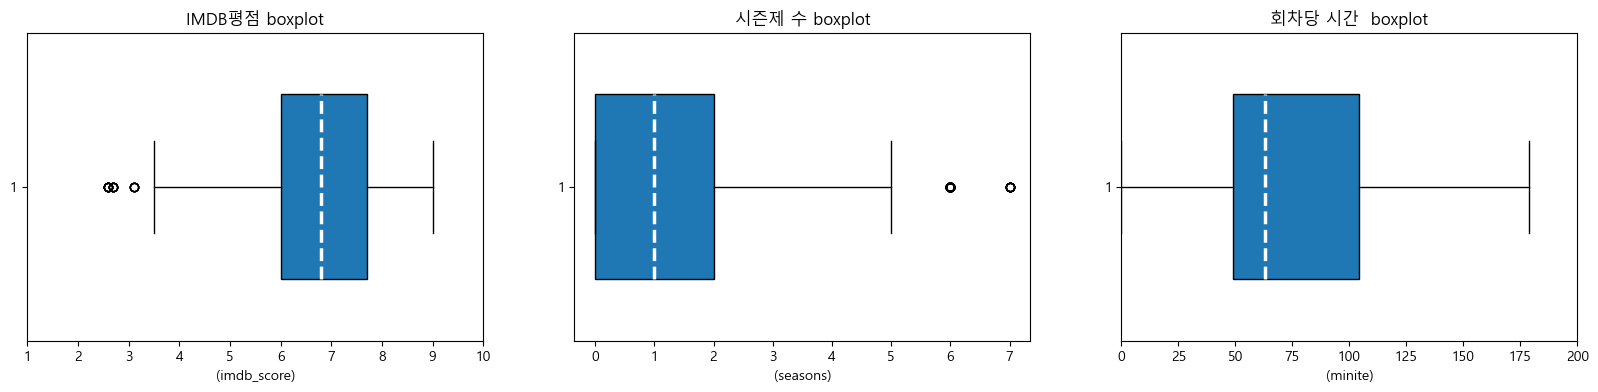

In [37]:
boxplot_df = top10_ready[['imdb_score', 'seasons', 'runtime']]
boxplot_df = boxplot_df.dropna(subset=['imdb_score', 'runtime'], how='any')
medianprops = dict(linestyle='--', linewidth=2.5, color='white')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,4))

axs[0].boxplot(boxplot_df['imdb_score'], vert= False, medianprops=medianprops, patch_artist=True, widths = 0.6)
axs[0].set_xlabel('(imdb_score)')
axs[0].set_xlim([1, 10])
axs[0].set_title('IMDB평점 boxplot')

axs[1].boxplot(boxplot_df['seasons'], vert=False, medianprops=medianprops, patch_artist=True, widths = 0.6)
axs[1].set_xlabel('(seasons)')
axs[1].set_title('시즌제 수 boxplot')

axs[2].boxplot(boxplot_df['runtime'], vert = False, medianprops=medianprops, patch_artist=True, widths = 0.6)
axs[2].set_xlim([0, 200])
axs[2].set_xlabel('(minite)')
axs[2].set_title('회차당 시간  boxplot')

# plt.savefig('boxplot.png')

plt.show()

In [38]:
quartertest.columns

Index(['week', 'weekly_rank', 'title', 'season_title', 'weekly_hours_viewed',
       'cumulative_weeks_in_top_10', 'language', 'type_x', 'release_year',
       'runtime', 'seasons', 'imdb_score', 'top10_stayed_weeks',
       'total_hours_viewed', 'genre_action', 'genre_adventure',
       'genre_animation', 'genre_biography', 'genre_comedy', 'genre_crime',
       'genre_documentary', 'genre_drama', 'genre_european', 'genre_family',
       'genre_fantasy', 'genre_game-show', 'genre_history', 'genre_horror',
       'genre_medical', 'genre_music', 'genre_mystery', 'genre_political',
       'genre_reality', 'genre_romance', 'genre_scifi', 'genre_short',
       'genre_sport', 'genre_thriller', 'genre_war', 'genre_western',
       'english_films', 'non_english_films', 'english_tv', 'non_english_tv',
       'age_certification_G', 'NC_17', 'age_certification_PG',
       'age_certification_PG-13', 'R', 'age_certification_TV-14',
       'age_certification_TV-G', 'TV_MA', 'age_certification_TV-PG'

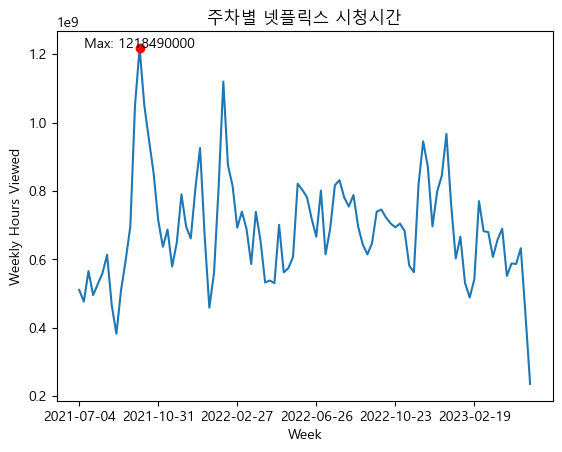

In [39]:

cnt_df = top10_ready[['week', 'weekly_hours_viewed']]
group_df = cnt_df.groupby(by=['week'], dropna=False)
weekly_total_hours = group_df.sum().reset_index()


users['quarter_end'] = pd.to_datetime(users['quarter_end'])
users['YearQuarter'] = users['quarter_end'].dt.to_period('Q')
users['global_users'] = users['global_users'].astype("int")
users_sorted = users.sort_values('YearQuarter')
users_sorted['YearQuarter'] = users_sorted['YearQuarter'].apply(lambda x: str(x).split("Q")[0] + "-" + str(x).split("Q")[1])



# 주차별 넷플릭스 시청시간
max_value = weekly_total_hours['weekly_hours_viewed'].max()
max_index = weekly_total_hours['weekly_hours_viewed'].idxmax()

fig, ax = plt.subplots()

ax.plot(weekly_total_hours['week'], weekly_total_hours['weekly_hours_viewed'])
ax.plot(max_index, max_value, marker = 'o', color = 'red')
ax.set_xlabel('Week')
ax.set_ylabel('Weekly Hours Viewed')
ax.set_title('주차별 넷플릭스 시청시간')
xticks = ax.get_xticks()
xticks = xticks[::17] 
ax.set_xticks(xticks)

ax.annotate(f'Max: {max_value}', xy = (max_index, max_value), xytext = (max_index, max_value-100), ha= 'center')

# plt.savefig("주차별 넷플릭스 시청시간")

plt.show()



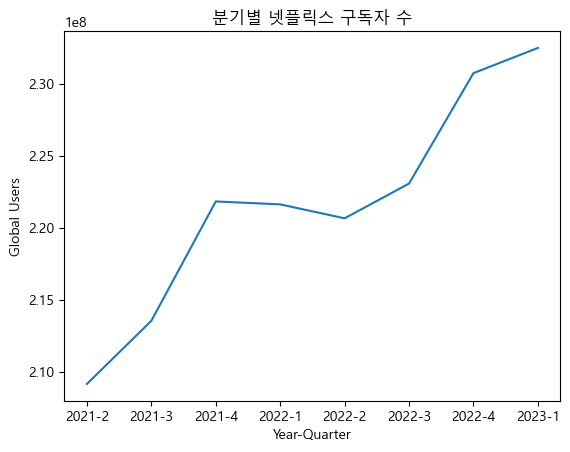

In [40]:
# 분기별 넷플릭스 구독자 수

fig,ax = plt.subplots()

ax.plot(users_sorted['YearQuarter'], users_sorted['global_users'])
ax.set_xlabel('Year-Quarter')
ax.set_ylabel('Global Users')
ax.set_title('분기별 넷플릭스 구독자 수')
plt.savefig('분기별구독자')
plt.show()

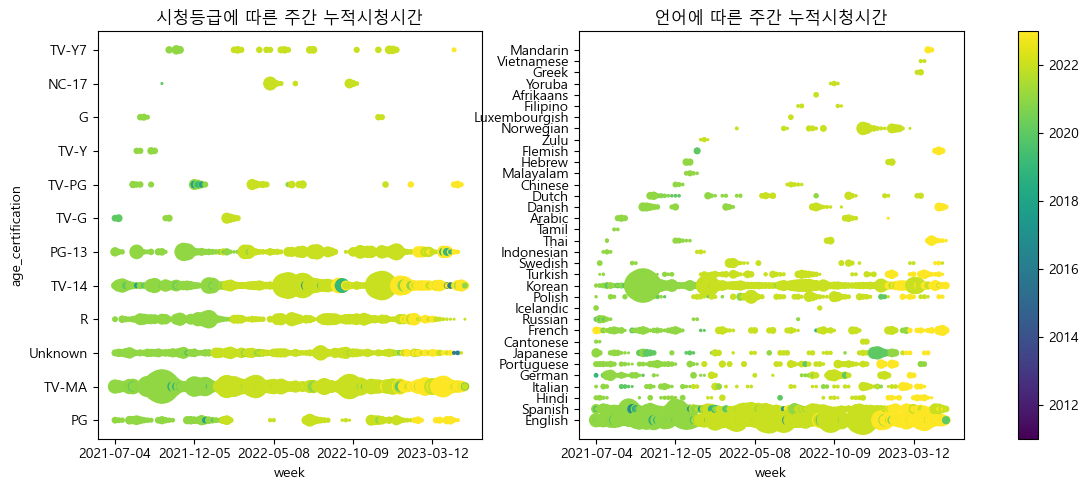

In [41]:
fig = plt.figure(figsize=(12, 5))

top10_ready = top10_ready.sort_values('week')

ax1 = fig.add_subplot(1, 2, 1)
sc1 = ax1.scatter(top10_ready['week'], top10_ready['age_certification'], s=top10_ready["weekly_hours_viewed"]/1000000, c=top10_ready["release_year"], cmap="viridis")
ax1.set_title("시청등급에 따른 주간 누적시청시간")
ax1.set_xlabel('week')
ax1.set_ylabel('age_certification')
xticks = ax1.get_xticks()
xticks = xticks[::22] 
ax1.set_xticks(xticks)


ax2 = fig.add_subplot(1, 2, 2)
sc2 = ax2.scatter(top10_ready["week"], top10_ready["language"], s=top10_ready["weekly_hours_viewed"]/1000000, c=top10_ready["release_year"], cmap="viridis")
ax2.set_title("언어에 따른 주간 누적시청시간")
ax2.set_xlabel('week')
xticks = ax2.get_xticks()
xticks = xticks[::22] 
ax2.set_xticks(xticks)


plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax1, ax2])


# plt.savefig("주간누적시청시간.png")

plt.show()

## 변수 검정과 변수들간 상관관계 분석

In [42]:
continuous_variables = ['seasons', 'imdb_score', 'top10_stayed_weeks', 'runtime', 'global_users']

for variable in continuous_variables:
    statistic, p_value = stats.shapiro(quartertest[variable])
    print(f"{variable}의 Shapiro-Wilk Test 결과:, Statistic: {statistic}, p-value: {p_value}")

seasons의 Shapiro-Wilk Test 결과:, Statistic: 0.8020981550216675, p-value: 0.0
imdb_score의 Shapiro-Wilk Test 결과:, Statistic: nan, p-value: 1.0
top10_stayed_weeks의 Shapiro-Wilk Test 결과:, Statistic: 0.7844306230545044, p-value: 0.0
runtime의 Shapiro-Wilk Test 결과:, Statistic: nan, p-value: 1.0
global_users의 Shapiro-Wilk Test 결과:, Statistic: 0.8731616139411926, p-value: 0.0


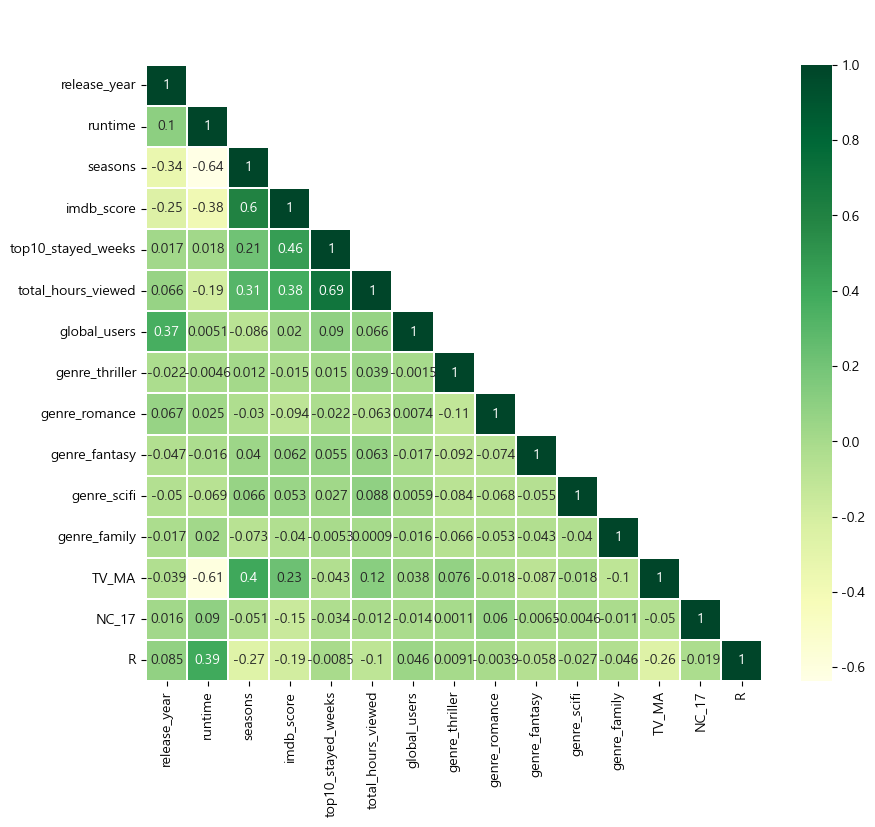

In [43]:
corr_df = quartertest[['release_year','runtime', 'seasons', 'imdb_score', 'top10_stayed_weeks', 'total_hours_viewed', 'global_users',
                'genre_thriller', 'genre_romance', 'genre_fantasy', 'genre_scifi', 'genre_family', 'TV_MA', 'NC_17', 'R']].corr()

colormap = plt.cm.YlGn

plt.figure(figsize=(10, 8))
plt.title("독립변수간 상관관계", y = 1.05, size = 15, color='white')

mask = np.array(corr_df)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(corr_df, linewidths=0.1, vmax=1.0, cmap=colormap, mask=mask,
            square=True, annot=True)

plt.xticks()
plt.yticks() 
# plt.savefig("corr.png")

plt.show() 

#### 더미변수 ANOVA 분석

In [44]:
GRP_TV_MA = quartertest[quartertest['TV_MA'] == 1]['total_hours_viewed']
GRP_R = quartertest[quartertest['R'] == 1]['total_hours_viewed']
GRP_NC_17 = quartertest[quartertest['NC_17'] == 1]['total_hours_viewed']

bartlett_result = stats.bartlett(GRP_TV_MA, GRP_R, GRP_NC_17)
print("Bartlett Test p-value:", bartlett_result.pvalue)


f_statistic, p_value = stats.f_oneway(GRP_TV_MA, GRP_R, GRP_NC_17)
print("ANOVA F-statistic:", f_statistic)
print("ANOVA p-value:", p_value)

Bartlett Test p-value: 0.0
ANOVA F-statistic: 75.36627204561161
ANOVA p-value: 7.082800491838816e-33


In [45]:
GRP_before = quartertest[quartertest['release_year'] < 2020]["total_hours_viewed"]
GRP_2020 = quartertest[quartertest['release_year'] == 2020]["total_hours_viewed"]
GRP_2021 = quartertest[quartertest['release_year'] == 2021]["total_hours_viewed"]
GRP_2022 = quartertest[quartertest['release_year'] == 2022]["total_hours_viewed"]
GRP_2023 = quartertest[quartertest['release_year'] == 2023]["total_hours_viewed"]

bartlett_result = stats.bartlett(GRP_before, GRP_2020, GRP_2021, GRP_2022, GRP_2023)
print("Bartlett Test p-value:", bartlett_result.pvalue)

stats.f_oneway(GRP_before, GRP_2020, GRP_2021, GRP_2022, GRP_2023)
print("ANOVA F-statistic:", f_statistic)
print("ANOVA p-value:", p_value)

Bartlett Test p-value: 0.0
ANOVA F-statistic: 75.36627204561161
ANOVA p-value: 7.082800491838816e-33


In [46]:
GRP_drama = quartertest[quartertest['genre_drama'] == 1]['total_hours_viewed']
GRP_comedy = quartertest[quartertest['genre_comedy'] == 1]['total_hours_viewed']
GRP_thriller = quartertest[quartertest['genre_thriller'] == 1]['total_hours_viewed']
GRP_crime = quartertest[quartertest['genre_crime'] == 1]['total_hours_viewed']
GRP_action = quartertest[quartertest['genre_action'] == 1]['total_hours_viewed']
GRP_romance = quartertest[quartertest['genre_romance'] == 1]['total_hours_viewed']
GRP_fantasy= quartertest[quartertest['genre_fantasy'] == 1]['total_hours_viewed']
GRP_scifi = quartertest[quartertest['genre_scifi'] == 1]['total_hours_viewed']
GRP_documentary= quartertest[quartertest['genre_documentary'] == 1]['total_hours_viewed']
GRP_family = quartertest[quartertest['genre_family'] == 1]['total_hours_viewed']


bartlett_result = stats.bartlett(GRP_drama, GRP_comedy, GRP_thriller, GRP_crime, GRP_action, GRP_romance, GRP_fantasy, GRP_scifi, GRP_documentary, GRP_family)
print("Bartlett Test p-value:", bartlett_result.pvalue)

stats.f_oneway(GRP_drama, GRP_comedy, GRP_thriller, GRP_crime, GRP_action, GRP_romance, GRP_fantasy, GRP_scifi, GRP_documentary, GRP_family)
print("ANOVA F-statistic:", f_statistic)
print("ANOVA p-value:", p_value)

Bartlett Test p-value: 3.7903791087741145e-268
ANOVA F-statistic: 75.36627204561161
ANOVA p-value: 7.082800491838816e-33


# 회귀분석

In [47]:
formula = 'total_hours_viewed ~ seasons + imdb_score + top10_stayed_weeks + runtime + release_year + \
           genre_thriller + genre_romance + genre_fantasy +genre_scifi + genre_family + TV_MA + R + NC_17 + global_users'

result = smf.ols(formula, quartertest).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     total_hours_viewed   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     704.7
Date:                Fri, 21 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:33:28   Log-Likelihood:            -1.7097e+05
No. Observations:                8223   AIC:                         3.420e+05
Df Residuals:                    8208   BIC:                         3.421e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -7.03e+10   5.24

In [48]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(result.model.exog, i)}
              for i, column in enumerate(result.model.exog_names)
              if column != 'Intercept')

,컬럼,VIF
0,seasons,2.507585
1,imdb_score,2.058932
2,top10_stayed_weeks,1.407834
3,runtime,2.592139
4,release_year,1.379202
5,genre_thriller,1.050493
6,genre_romance,1.049199
7,genre_fantasy,1.051968
8,genre_scifi,1.037394
9,genre_family,1.043997
